In [113]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
# Cargar el dataset original
file_path = 'houses_Madrid.xlsx'
df = pd.read_excel(file_path)

# Verificar que se ha cargado correctamente
print(df.shape)
df.head()




(21742, 58)


,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
4,4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,...,en trámite,True,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0


In [115]:
columns_to_keep = ['neighborhood_id', 'is_renewal_needed', 'has_garden', 'energy_certificate', 'is_new_development', 'n_bathrooms', 'has_lift',
    'built_year', 'buy_price_by_area']

df = df[columns_to_keep]

print(df.columns.tolist())
df.head()

# Guardar el DataFrame actualizado en un nuevo archivo Excel
df.to_excel('first.xlsx', index=False)


['neighborhood_id', 'is_renewal_needed', 'has_garden', 'energy_certificate', 'is_new_development', 'n_bathrooms', 'has_lift', 'built_year', 'buy_price_by_area']


In [116]:
# Definir función mejorada
def split_neighborhood_info(text):
    try:
        match = re.match(
            r"Neighborhood (\d+): (.+?) \(([\d.,Nn][\d.,None]*) €/m2\) - District (\d+): (.+)", 
            text
        )
        if match:
            neighborhood_num = int(match.group(1))
            neighborhood_name = match.group(2)
            price_raw = match.group(3)
            # Detectar si es 'None' o un número
            if 'None' in price_raw or 'none' in price_raw:
                price_per_m2 = np.nan
            else:
                price_per_m2 = float(price_raw.replace(',', ''))
            district_id = int(match.group(4))
            district_name = match.group(5)
            return pd.Series([neighborhood_num, neighborhood_name, price_per_m2, district_id, district_name])
        else:
            return pd.Series([None, None, None, None, None])
    except Exception as e:
        print(f"Error processing row: {text}")
        print(e)
        return pd.Series([None, None, None, None, None])

In [117]:
df[['neighborhood_num', 'neighborhood_name', 'price_per_m2', 'district_id', 'district_name']] = df['neighborhood_id'].apply(split_neighborhood_info)

df[['neighborhood_num', 'neighborhood_name', 'price_per_m2', 'district_id', 'district_name']].head()




,neighborhood_num,neighborhood_name,price_per_m2,district_id,district_name
0,135,San Cristóbal,1308.89,21,Villaverde
1,132,Los Ángeles,1796.68,21,Villaverde
2,134,San Andrés,1617.18,21,Villaverde
3,134,San Andrés,1617.18,21,Villaverde
4,133,Los Rosales,1827.79,21,Villaverde


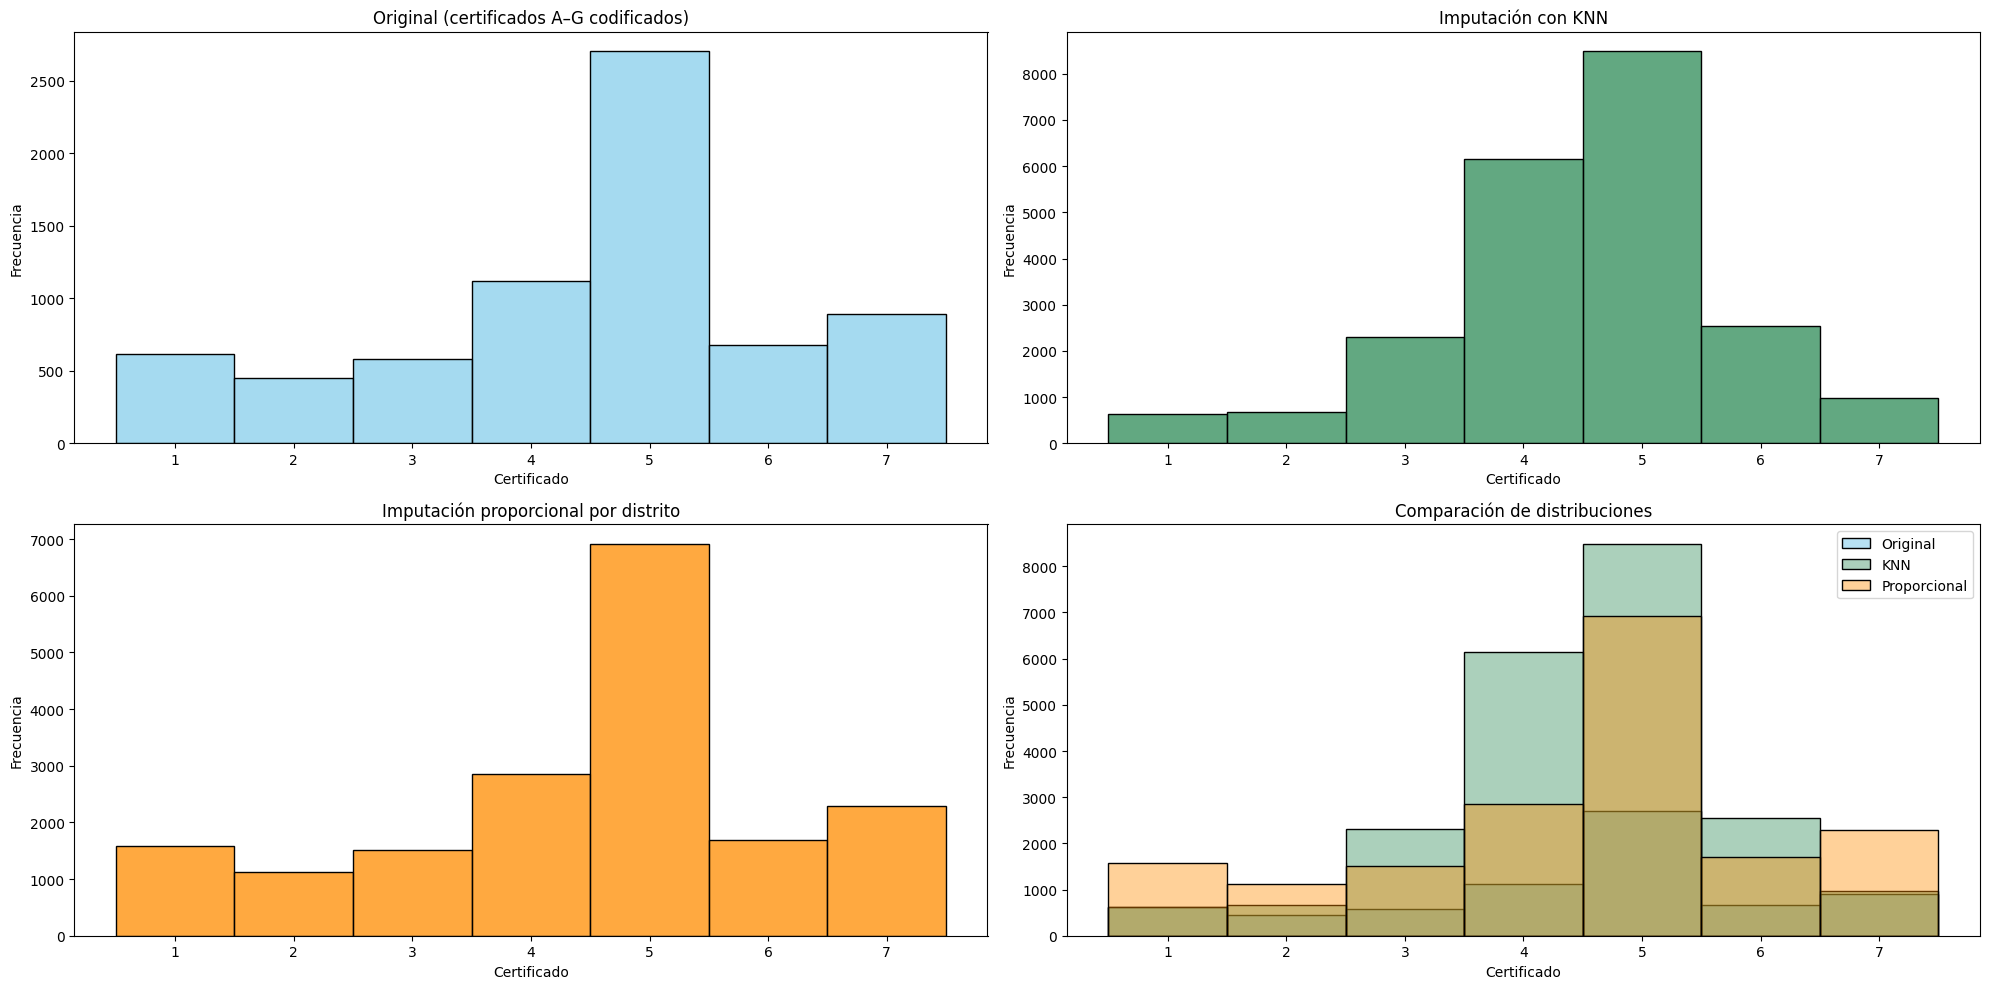

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

# Codificación ordinal
cert_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['energy_certificate_num'] = df['energy_certificate'].map(cert_map)

# ----- Imputación proporcional por distrito -----
certs_validos = list(cert_map.keys())
dist_por_distrito = (
    df[df['energy_certificate'].isin(certs_validos)]
    .groupby('district_name')['energy_certificate']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

def imputar_por_distrito(row):
    if row['energy_certificate'] == 'en trámite':
        distrito = row['district_name']
        if distrito in dist_por_distrito.index:
            probs = dist_por_distrito.loc[distrito]
            return np.random.choice(probs.index, p=probs.values)
    return row['energy_certificate']

df['energy_certificate_proporcional'] = df.apply(imputar_por_distrito, axis=1)
df['energy_certificate_proporcional_num'] = df['energy_certificate_proporcional'].map(cert_map)

# ----- Imputación con KNN -----
features_for_knn = [
    'is_new_development', 'n_bathrooms', 'has_lift',
    'built_year', 'buy_price_by_area', 'energy_certificate_num'
]
df_knn = df[features_for_knn].copy()

imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=features_for_knn)
df['energy_certificate_knn'] = df_knn_imputed['energy_certificate_num'].round().astype('Int64')

# ----- Gráficos -----
plt.figure(figsize=(20, 10))

# Original
plt.subplot(2, 2, 1)
sns.histplot(df['energy_certificate_num'].dropna(), bins=range(1, 9), discrete=True, color='skyblue')
plt.title("Original (certificados A–G codificados)")
plt.xlabel("Certificado")
plt.ylabel("Frecuencia")

# KNN
plt.subplot(2, 2, 2)
sns.histplot(df['energy_certificate_knn'], bins=range(1, 9), discrete=True, color='seagreen')
plt.title("Imputación con KNN")
plt.xlabel("Certificado")
plt.ylabel("Frecuencia")

# Proporcional por distrito
plt.subplot(2, 2, 3)
sns.histplot(df['energy_certificate_proporcional_num'], bins=range(1, 9), discrete=True, color='darkorange')
plt.title("Imputación proporcional por distrito")
plt.xlabel("Certificado")
plt.ylabel("Frecuencia")

# Comparación superpuesta
plt.subplot(2, 2, 4)
sns.histplot(df['energy_certificate_num'].dropna(), bins=range(1, 9), discrete=True, label='Original', color='skyblue', alpha=0.6)
sns.histplot(df['energy_certificate_knn'], bins=range(1, 9), discrete=True, label='KNN', color='seagreen', alpha=0.4)
sns.histplot(df['energy_certificate_proporcional_num'], bins=range(1, 9), discrete=True, label='Proporcional', color='darkorange', alpha=0.4)
plt.title("Comparación de distribuciones")
plt.xlabel("Certificado")
plt.ylabel("Frecuencia")
plt.legend()

plt.tight_layout()
plt.show()

df.drop(columns=['energy_certificate'], inplace=True)
df.rename(columns={'energy_certificate_knn': 'energy_certificate'}, inplace=True)



Antes de imputar:
- NaNs: 82 / 21742
- Porcentaje: 0.38%

Después de imputar:
- NaNs: 0 / 21742
- Porcentaje: 0.00%



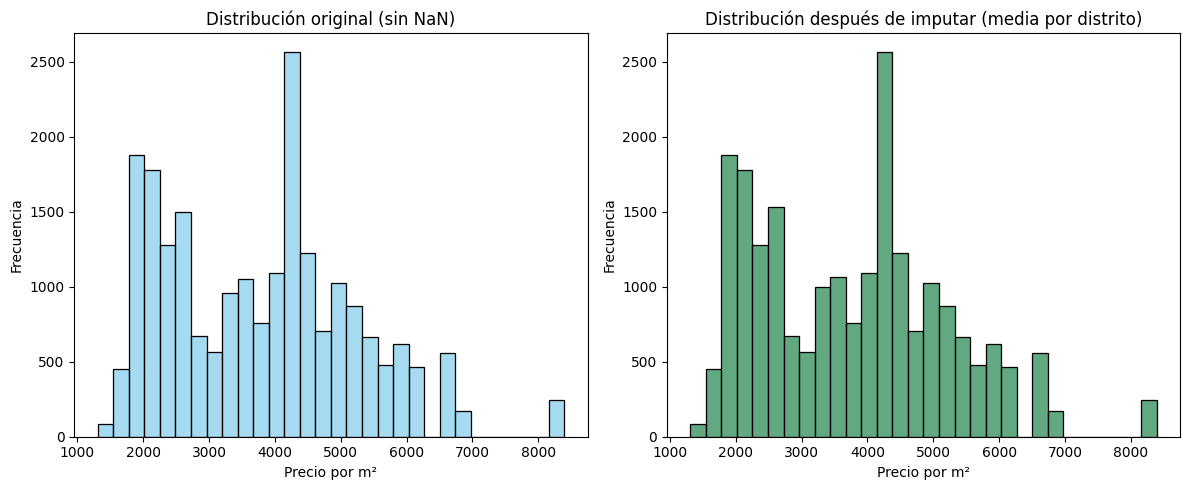

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (1) Mostrar count y porcentaje de NaNs antes de imputar
total = len(df)
n_nan_before = df['price_per_m2'].isna().sum()
pct_nan_before = n_nan_before / total * 100
print(f"Antes de imputar:")
print(f"- NaNs: {n_nan_before} / {total}")
print(f"- Porcentaje: {pct_nan_before:.2f}%\n")

# (2) Crear copia antes de imputar para graficar
df_before = df.copy()

# (3) Calcular la media de cada distrito
district_means = df.groupby('district_id')['price_per_m2'].mean()

# (4) Imputar NaNs con la media del distrito
df['price_per_m2'] = df.apply(
    lambda row: district_means[row['district_id']] if pd.isna(row['price_per_m2']) else row['price_per_m2'],
    axis=1
)

# (5) Mostrar count y porcentaje de NaNs después de imputar
n_nan_after = df['price_per_m2'].isna().sum()
pct_nan_after = n_nan_after / total * 100
print(f"Después de imputar:")
print(f"- NaNs: {n_nan_after} / {total}")
print(f"- Porcentaje: {pct_nan_after:.2f}%\n")

# (6) Graficar la distribución antes y después
plt.figure(figsize=(12, 5))

# Antes de imputar
plt.subplot(1, 2, 1)
sns.histplot(df_before['price_per_m2'].dropna(), bins=30, color='skyblue')
plt.title("Distribución original (sin NaN)")
plt.xlabel("Precio por m²")
plt.ylabel("Frecuencia")

# Después de imputar
plt.subplot(1, 2, 2)
sns.histplot(df['price_per_m2'], bins=30, color='seagreen')
plt.title("Distribución después de imputar (media por distrito)")
plt.xlabel("Precio por m²")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


In [120]:
# Normalizar columna 'has_garden': 1.0 -> 1, NaN -> 0
df['has_garden'] = df['has_garden'].apply(lambda x: 1 if x == 1.0 else 0)

# Verificar cambios
print(df['has_garden'].value_counts())


has_garden
0    20186
1     1556
Name: count, dtype: int64


In [121]:
# Normalizar columna 'has_garden': 1.0 -> 1, NaN -> 0
df['is_renewal_needed'] = df['is_renewal_needed'].apply(lambda x: 1 if x == True else 0)

# Verificar cambios
print(df['has_garden'].value_counts())


has_garden
0    20186
1     1556
Name: count, dtype: int64


In [122]:
# Lista de columnas a eliminar
cols_to_drop = [
    'neighborhood_id',
    'neighborhood_num',
    'energy_certificate_num',
    'energy_certificate_knn',
    'energy_certificate_proporcional',
    'energy_certificate_proporcional_num',
    'is_new_development',
    'n_bathrooms',
    'has_lift',
    'built_year',
    'buy_price_by_area',
    'district_name',
    'neighborhood_name'


    # Añade aquí cualquier otra que no quieras usar
]

# Eliminar columnas si existen en el DataFrame
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Mostrar columnas restantes
print("Columnas restantes:")
print(df.columns.tolist())


Columnas restantes:
['is_renewal_needed', 'has_garden', 'price_per_m2', 'district_id', 'energy_certificate']


In [123]:
# Guardar el DataFrame actualizado en un nuevo archivo Excel
df.to_excel('preprocessing2.xlsx', index=False)
